In [1]:
from itertools import combinations
# this is optional and only used to generate watermark information about this project
%load_ext watermark

In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import silhouette_score, adjusted_rand_score, accuracy_score

from src.classifier.expectationMaximisation import ExpectationMaximisation
from src.classifier.kmeans import KMeans
from src.transformers.pca import PCA
from src.transformers.standardScaler import StandardScaler

sns.set_theme()

Dans le but de facilité la réplication des résultats, vous trouverez à la suite les informations du système utilisé lors de la génération du système. De plus, il est primordial d'exécuter les cellules du notebook dans l'ordre puisque nous mettons parfois à jour certains objets utilisé précédemment rendant la fonction alors non fonctionnelle (suite à la perte ou a la modification de certaines données). Enfin, on fixe la graine aléatoire pour la reproductibilité des résultats.

In [3]:
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.0.12-arch1-1
Machine     : x86_64
Processor   : 
CPU cores   : 16
Architecture: 64bit

seaborn   : 0.12.1
scipy     : 1.9.3
pandas    : 1.5.2
matplotlib: 3.6.2
sklearn   : 1.1.3
numpy     : 1.23.5



In [4]:
np.random.seed(31415)

# Présentation des données et analyse descriptive

Le jeu de donnée que nous allons étudier est [SPECTF Heart Data Set](https://archive.ics.uci.edu/ml/datasets/SPECTF+Heart). Les données décrivent le diagnostic de perfusion myocardique à l'aide d'images de tomographie par émission monophotonique (ou SPECT acronyme du nom de la méthode en anglais "Single photon emission computed tomography") cardiaques. Rappelons tout d'abord que la tomographie par émission monophotonique est une technique se basant sur la scintigraphie et qui utilise un ensemble de caméras gamma tournant autour du patient pour produire des images et des reconstructions en 3D des organes et de leur métabolisme. Du fait le la complexité d'utilisé des données d'imagerie 3D en machines learning (que ce soit en taille, ou en puissance de calcul), la base de données de 267 ensembles d'images SPECT (patients) a été traitée pour extraire les caractéristiques qui résument les images SPECT originales. Les données sont donc résumées en 44 caractéristiques continues pour chacun des patients et sont de la forme :

- F$n$R : qui représente le nombre moyen de pixels après traitement de l'image localisé dans la zone d'intérêts $n$ au repos pour $n$ allant de 1 à 22.
- F$n$S : qui représente le nombre moyen de pixels après traitement de l'image localisé dans la zone d'intérêts $n$ dans des conditions de stress pour $n$ allant de 1 à 22.

Toutes ces variables sont des entiers allant de 0 à 100. Chacun des patients est classé en deux catégories : normal et anormal et un algorithme a été utilisé (CLIP3) pour prédire un diagnostic (colonne `OVERALL_DIAGNOSIS` donc en réalité 45 attributs si nous prenons en compte cette colonne), nous savons également que cet algorithme avait une précision de 77% par rapport aux diagnostics des cardiologistes.

Le jeu de donnée de 267 individus est séparé en 2 fichiers :
- `SPECTF.train` contenant des données pouvant être utilisé pour entrainer nos algorithmes, comprenant seulement 80 individus sur les 269
- `SPECTF.test` contenant ici des données pouvant être utilisé pour valider les résultats des algorithmes entrainer au préalable, qui lui comprend les 187 individus restants

Lors de ce projet, nous utiliserons uniquement des algorithmes non supervisés ainsi il n'est pas nécéssaire de séparer les données, nous pouvons donc regrouper ces deux fichiers dans un seul dataframe panda à l'aide de la fonction `read_csv` de panda :


In [5]:
df = pd.concat(
	map(
		lambda file: pd.read_csv(
			file,
			names=["OVERALL_DIAGNOSIS", "F1R", "F1S", "F2R", "F2S", "F3R", "F3S", "F4R", "F4S", "F5R", "F5S", "F6R",
				   "F6S", "F7R", "F7S", "F8R", "F8S", "F9R", "F9S", "F10R", "F10S", "F11R", "F11S", "F12R", "F12S",
				   "F13R", "F13S", "F14R", "F14S", "F15R", "F15S", "F16R", "F16S", "F17R", "F17S", "F18R", "F18S",
				   "F19R", "F19S", "F20R", "F20S", "F21R", "F21S", "F22R", "F22S"],
		),
		["data/SPECTF.test", "data/SPECTF.train"],
	)
)

print(df.shape)
df.head()

(267, 45)


,OVERALL_DIAGNOSIS,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,1,67,68,73,78,65,63,67,60,63,...,61,56,76,75,74,77,76,74,59,68
1,1,75,74,71,71,62,58,70,64,71,...,66,62,68,69,69,66,64,58,57,52
2,1,83,64,66,67,67,74,74,72,64,...,67,64,69,63,68,54,65,64,43,42
3,1,72,66,65,65,64,61,71,78,73,...,69,68,68,63,71,72,65,63,58,60
4,1,62,60,69,61,63,63,70,68,70,...,66,66,58,56,72,73,71,64,49,42


Nous avons bien un dataframe de 267 individus et 45 variables. Dans un premier temps, nous séparons les valeurs que nous allons chercher à prédire à l'aide de nos différents algorithmes, pour cela on sauvegarde la colonne dans une nouvelle variable et on supprime la colonne du dataframe.

In [6]:
labels = df.OVERALL_DIAGNOSIS
df.drop(columns=["OVERALL_DIAGNOSIS"], inplace=True)

df.head()

,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,F5S,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
0,67,68,73,78,65,63,67,60,63,62,...,61,56,76,75,74,77,76,74,59,68
1,75,74,71,71,62,58,70,64,71,68,...,66,62,68,69,69,66,64,58,57,52
2,83,64,66,67,67,74,74,72,64,68,...,67,64,69,63,68,54,65,64,43,42
3,72,66,65,65,64,61,71,78,73,69,...,69,68,68,63,71,72,65,63,58,60
4,62,60,69,61,63,63,70,68,70,65,...,66,66,58,56,72,73,71,64,49,42


Réalisons a présent une analyse descriptive des données :

In [7]:
df.describe()

,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,F5S,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,...,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,66.183521,64.913858,68.677903,69.078652,64.801498,63.966292,70.168539,69.389513,63.295880,62.232210,...,63.906367,62.584270,65.247191,64.198502,65.902622,64.052434,62.438202,60.411985,52.580524,50.535581
std,8.250315,9.444937,6.593543,8.394267,8.826328,9.479835,8.355678,9.497030,9.020783,9.340188,...,7.937410,10.948075,7.885383,9.251393,12.086696,12.693505,14.436760,15.200500,12.809920,14.548133
min,23.000000,21.000000,38.000000,34.000000,21.000000,25.000000,21.000000,20.000000,12.000000,22.000000,...,18.000000,13.000000,33.000000,18.000000,11.000000,6.000000,5.000000,8.000000,11.000000,4.000000
25%,62.000000,60.000000,65.000000,66.000000,61.000000,60.000000,68.000000,67.000000,61.000000,58.000000,...,62.000000,61.000000,62.000000,60.000000,62.500000,60.000000,59.500000,56.000000,49.000000,45.000000
50%,67.000000,66.000000,69.000000,71.000000,66.000000,66.000000,72.000000,72.000000,65.000000,64.000000,...,66.000000,65.000000,66.000000,66.000000,69.000000,67.000000,67.000000,65.000000,56.000000,55.000000
75%,71.500000,71.000000,73.000000,74.000000,70.000000,70.000000,75.000000,75.000000,68.000000,68.000000,...,68.000000,69.000000,71.000000,71.000000,73.000000,72.000000,72.000000,70.000000,61.000000,60.000000
max,83.000000,81.000000,82.000000,84.000000,82.000000,89.000000,85.000000,83.000000,77.000000,78.000000,...,76.000000,77.000000,80.000000,79.000000,83.000000,81.000000,82.000000,83.000000,82.000000,73.000000


Nous pouvons remarquer qu'il n'y a aucune donnée atypique ou manquante, réalisons maintenant la matrice de corrélation pour voir s'il y a corrélation entre les différentes variable.

In [8]:
df.corr().style.background_gradient(cmap="coolwarm").format(precision=2)

,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,F5S,F6R,F6S,F7R,F7S,F8R,F8S,F9R,F9S,F10R,F10S,F11R,F11S,F12R,F12S,F13R,F13S,F14R,F14S,F15R,F15S,F16R,F16S,F17R,F17S,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
F1R,1.00,0.59,0.36,0.36,0.19,0.21,0.57,0.40,0.50,0.39,0.24,0.18,0.04,0.08,0.12,0.15,0.41,0.37,0.11,0.16,0.16,0.10,0.04,0.07,0.06,0.02,0.12,0.05,0.40,0.31,0.15,0.19,0.06,-0.02,0.36,0.29,0.26,0.21,0.40,0.29,0.07,0.08,0.00,0.04
F1S,0.59,1.00,0.29,0.46,0.07,0.32,0.40,0.53,0.41,0.60,0.25,0.43,0.02,0.10,-0.01,0.11,0.29,0.37,0.11,0.26,0.08,0.18,-0.03,0.10,0.01,0.04,0.10,0.15,0.41,0.47,0.18,0.25,0.02,0.08,0.33,0.39,0.24,0.45,0.35,0.46,0.05,0.07,-0.00,0.07
F2R,0.36,0.29,1.00,0.62,0.18,0.16,0.29,0.15,0.25,0.24,0.45,0.35,0.25,0.26,0.08,0.06,0.16,0.11,0.12,0.09,0.16,0.16,0.10,0.13,0.11,0.12,0.08,0.05,0.33,0.23,0.45,0.30,0.26,0.07,0.16,0.15,0.25,0.24,0.29,0.24,0.16,0.13,0.09,0.10
F2S,0.36,0.46,0.62,1.00,0.12,0.26,0.24,0.25,0.31,0.36,0.39,0.52,0.24,0.41,-0.00,0.11,0.10,0.06,0.17,0.27,0.20,0.24,0.19,0.31,0.17,0.15,0.09,-0.02,0.32,0.40,0.46,0.61,0.27,0.35,0.15,0.21,0.17,0.32,0.28,0.40,0.16,0.19,0.13,0.15
F3R,0.19,0.07,0.18,0.12,1.00,0.67,0.28,0.33,0.22,0.17,0.06,0.08,0.39,0.31,0.55,0.46,0.23,0.16,0.20,0.09,0.06,0.05,0.27,0.26,0.43,0.40,0.12,0.04,0.29,0.27,0.12,0.14,0.09,0.10,0.28,0.24,-0.02,-0.08,0.34,0.21,0.48,0.44,0.37,0.36
F3S,0.21,0.32,0.16,0.26,0.67,1.00,0.34,0.61,0.20,0.31,0.10,0.19,0.41,0.42,0.59,0.67,0.30,0.30,0.19,0.17,0.04,0.21,0.31,0.39,0.52,0.58,0.13,0.23,0.42,0.52,0.25,0.34,0.14,0.23,0.39,0.49,0.01,0.08,0.41,0.46,0.59,0.67,0.45,0.55
F4R,0.57,0.40,0.29,0.24,0.28,0.34,1.00,0.65,0.54,0.39,0.23,0.15,0.04,-0.03,0.30,0.35,0.68,0.61,0.19,0.16,0.20,0.08,0.04,0.02,0.15,0.14,0.35,0.26,0.45,0.42,0.11,0.15,-0.02,0.01,0.61,0.50,0.36,0.22,0.60,0.44,0.20,0.20,0.07,0.13
F4S,0.40,0.53,0.15,0.25,0.33,0.61,0.65,1.00,0.32,0.44,0.11,0.16,0.16,0.16,0.41,0.51,0.56,0.63,0.17,0.18,0.08,0.18,0.10,0.17,0.31,0.31,0.26,0.33,0.59,0.62,0.16,0.17,-0.02,0.01,0.62,0.71,0.18,0.29,0.59,0.61,0.37,0.40,0.25,0.32
F5R,0.50,0.41,0.25,0.31,0.22,0.20,0.54,0.32,1.00,0.74,0.50,0.41,0.27,0.15,0.32,0.36,0.63,0.60,0.46,0.43,0.28,0.18,0.15,0.08,0.22,0.13,0.34,0.14,0.44,0.40,0.26,0.26,0.07,0.13,0.52,0.44,0.46,0.41,0.48,0.35,0.19,0.14,0.08,0.09
F5S,0.39,0.60,0.24,0.36,0.17,0.31,0.39,0.44,0.74,1.00,0.41,0.56,0.28,0.25,0.30,0.31,0.55,0.62,0.30,0.47,0.15,0.28,0.08,0.13,0.19,0.17,0.27,0.23,0.47,0.53,0.28,0.27,0.05,0.14,0.50,0.56,0.34,0.53,0.42,0.47,0.17,0.16,0.08,0.13


Nous pouvons alors remarquer que globalement toutes les variables sont, lorsqu'il y a corrélation corrélée positivement, en effet : nous n'observons quasi-jamais de valeurs négatives, et lorsqu'elles sont négatives, elles sont très proches de 0 ce qui se traduit par une absence de corrélation entre les deux variables. De plus on observe également un schéma régulier, en effet : pour la même zone d'intérêts les données dans des conditions de repos et de stress sont, sauf exception, fortement corrélée. Enfin, on remarque une très forte corrélation positive entre les zones 21 et 22.

# Exploration des données par l’ACP normée
> (a) Construire la matrice des données centrées-réduites.

Pour cela nous utilisons la classe StandardScaler implémenter au préalable pour centrer, réduire automatiquement les données.

In [9]:
df = StandardScaler().fit_transform(df)
df.describe()

,F1R,F1S,F2R,F2S,F3R,F3S,F4R,F4S,F5R,F5S,...,F18R,F18S,F19R,F19S,F20R,F20S,F21R,F21S,F22R,F22S
count,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,...,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02,2.670000e+02
mean,-4.956501e-16,-5.255887e-16,-6.453431e-16,5.355683e-16,3.459571e-16,-1.995907e-16,-5.655069e-16,-6.653022e-16,2.594679e-16,-1.097749e-16,...,2.395088e-16,-2.395088e-16,-1.829581e-17,-3.259981e-16,-4.790176e-16,2.395088e-16,-2.794269e-16,1.330604e-16,-1.995907e-16,1.197544e-16
std,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,...,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00,1.001878e+00
min,-5.243996e+00,-4.658191e+00,-4.661456e+00,-4.186730e+00,-4.971915e+00,-4.118159e+00,-5.895497e+00,-5.210288e+00,-5.697090e+00,-4.315520e+00,...,-5.794406e+00,-4.537545e+00,-4.097169e+00,-5.003059e+00,-4.550931e+00,-4.581985e+00,-3.986079e+00,-3.454519e+00,-3.252059e+00,-3.204739e+00
25%,-5.080263e-01,-5.212407e-01,-5.588512e-01,-3.674452e-01,-4.315087e-01,-4.191782e-01,-2.600162e-01,-2.520789e-01,-2.549880e-01,-4.539692e-01,...,-2.406260e-01,-1.449793e-01,-4.125721e-01,-4.546760e-01,-2.820466e-01,-3.198521e-01,-2.039045e-01,-2.907977e-01,-2.800367e-01,-3.812157e-01
50%,9.914927e-02,1.152133e-01,4.894216e-02,2.293180e-01,1.360422e-01,2.149327e-01,2.195992e-01,2.753902e-01,1.892652e-01,1.896225e-01,...,2.642631e-01,2.210678e-01,9.564820e-02,1.950929e-01,2.567447e-01,2.326466e-01,3.165783e-01,3.024000e-01,2.674409e-01,3.074486e-01
75%,6.456073e-01,6.455916e-01,6.567355e-01,5.873759e-01,5.900828e-01,6.376734e-01,5.793107e-01,5.918717e-01,5.224551e-01,6.186837e-01,...,5.167077e-01,5.871149e-01,7.309236e-01,7.365670e-01,5.883085e-01,6.272886e-01,6.635668e-01,6.319543e-01,6.584964e-01,6.517808e-01
max,2.042111e+00,1.706348e+00,2.024271e+00,1.780902e+00,1.952205e+00,2.645691e+00,1.778349e+00,1.435822e+00,1.522025e+00,1.691337e+00,...,1.526486e+00,1.319209e+00,1.874419e+00,1.602926e+00,1.417218e+00,1.337644e+00,1.357544e+00,1.488795e+00,2.300930e+00,1.547044e+00


> (b) Réaliser une ACP normée (votre implémentation, voir bloc 1).

Ici, nous utilisons la classe PCA que nous avons également implémenté avant l'étude des données. Ici, nous avons initialisé la classe avec 2 clusters, mais cela n'a aucune importance puisque le nombre de clusters est toujours modifiable via un setter, et que le nombre de clusters n'influe pas lors du `fit` qui calcule les paramètres nécessaires à la réalisation de l'ACP, à savoir les valeurs propres et les vecteurs propre de la matrice de corrélation.

In [10]:
pca = PCA(2)
pca.fit(df)

> (c) Sélectionner le nombre optimal des composantes principales (c-à-d la dimension intrinsèque de l’ensemble des données) en utilisant le diagramme des éboulis ou une autre méthode. On note c ce nombre. Quelle proportion de la variance totale perd-t-on en gardant seulement les c composantes sélectionnées ?

Nous réalisons dans un premier temps le diagramme des éboulis, pour cela on utilise les valeurs propres issues de la matrice de corrélation des données. Ces valeurs sont disponibles dans l'attribut eigenvalues de la classe PCA:

Text(0, 0.5, 'Pourcentage de la variance représenté')

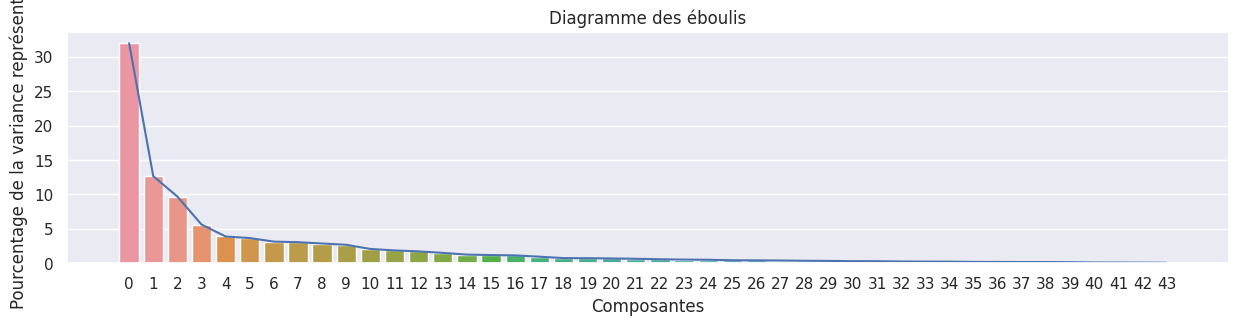

In [11]:
plt.figure(figsize=(15, 3))

sns.barplot(x=list(range(len(pca.eigenvalues))), y=pca.eigenvalues / sum(pca.eigenvalues) * 100)
sns.lineplot(x=range(len(pca.eigenvalues)), y=pca.eigenvalues / sum(pca.eigenvalues) * 100)
plt.title("Diagramme des éboulis")
plt.xlabel("Composantes")
plt.ylabel("Pourcentage de la variance représenté")

Au vu des résultats, nous pouvons en déduire que le coude se trouve au niveau de 2 composantes, nous pouvons alors décider que le nombre optimal de composantes principale est donc $c = 4$. Nous cherchons alors à calculer la proportion de variance totale que l'on perd en garant seulement les $c$ composantes. Pour cela on effectue le calcule suivant : Variance totale - intertie des $c$ composantes, or comme les donnée sont normalisé nous savons que la variance totale est égale à 1. Nous avons alors :

In [12]:
print(1 - sum((pca.eigenvalues / sum(pca.eigenvalues))[:4]))

0.40014640130985346


Ainsi, on remarque qu'avec $c=4$ nous perdons $0.40$ de la variance totale soit $40\%$ de la variance totale.

> (d) Analyse des individus
    - Représenter les individus sur le plan principal en utilisant pyplot.scatter. Donner le pourcentage d’inertie capturé par le plan principal.

Pour cela nous utilisons le setter de la classe PCA afin que lors transformation des données la classe ne retourne que $2$ composantes (plan principal). Ensuite pour calculer le pourcentage d'inertie capture par le plan principal, on calcule la somme suivante : $\[ \sum_{i=1}^{c} \frac{\lambda_i}{\sum \lambda}\]$

44.656166254994346


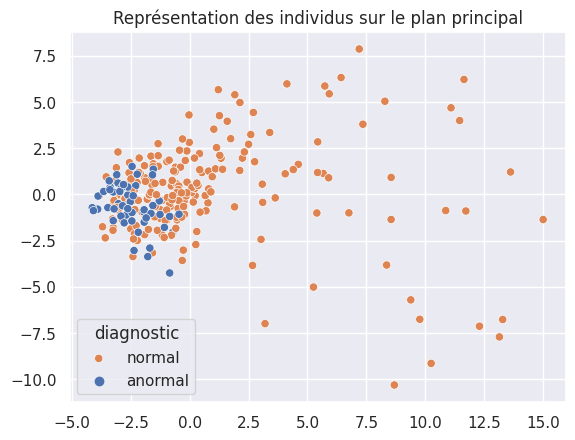

In [13]:
pca.set_n_components(2)
plotting_df = pca.transform(df)

sns.scatterplot(x=plotting_df[:, 0], y=plotting_df[:, 1], hue=labels)
plt.legend(title="diagnostic", labels=["normal", "anormal"])
plt.title("Représentation des individus sur le plan principal")

print(sum((pca.eigenvalues / sum(pca.eigenvalues) * 100)[:2]))

Ainsi, le pourcentage d'inertie capturé par le plan principale est de $44.6\%$.

> Colorer les points sur le scatter plot des individus en fonction de la qualité de leur représentation sur le plan principal

Pour récupérer la qualité de chacun des points on utilise la méthode `individual_quality` que nous avons au préalable implémenter dans la classe PCA:

Text(0.5, 1.0, 'Représentation des individus sur le plan principal colorés selon leurs qualités de représentation')

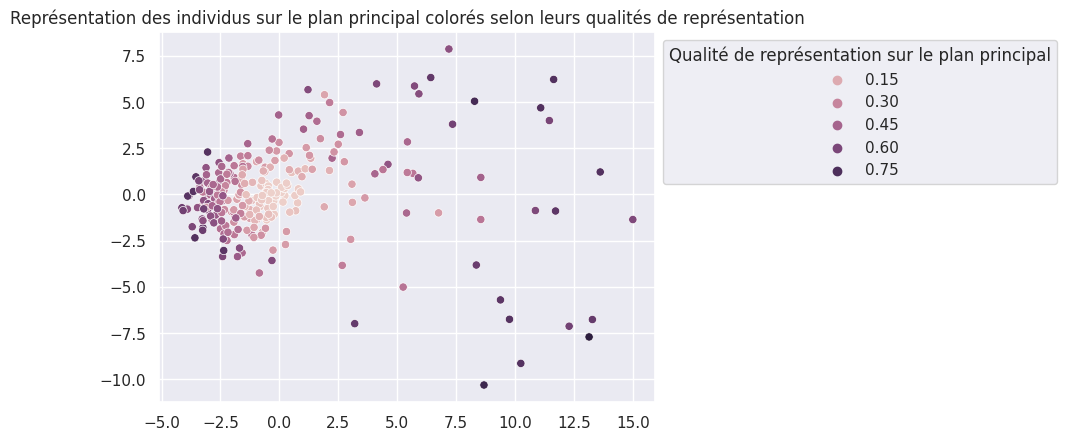

In [14]:
quality = pca.individual_quality(df)

sns.scatterplot(x=plotting_df[:, 0], y=plotting_df[:, 1], hue=quality)
plt.legend(title="Qualité de représentation sur le plan principal", bbox_to_anchor=(1, 1))
plt.title("Représentation des individus sur le plan principal colorés selon leurs qualités de représentation")

> Donnez les indices des 4 individus typiques (2 par composante) représentant les 2 premières composantes principales.


In [15]:
print(
	f"Les indices des individus typique pour l'axe 0 sont : individu minimal {plotting_df[:, 0].argmin()}, individu maximal {plotting_df[:, 0].argmax()}"
)
print(
	f"Les indices des individus typique pour l'axe 1 sont : individu minimal {plotting_df[:, 1].argmin()}, individu maximal {plotting_df[:, 1].argmax()}"
)

Les indices des individus typique pour l'axe 0 sont : individu minimal 237, individu maximal 157
Les indices des individus typique pour l'axe 1 sont : individu minimal 141, individu maximal 13


> (e) Analyse des variables.
> Représenter les variables dans le cercle de corrélations (voir formules en annexe).

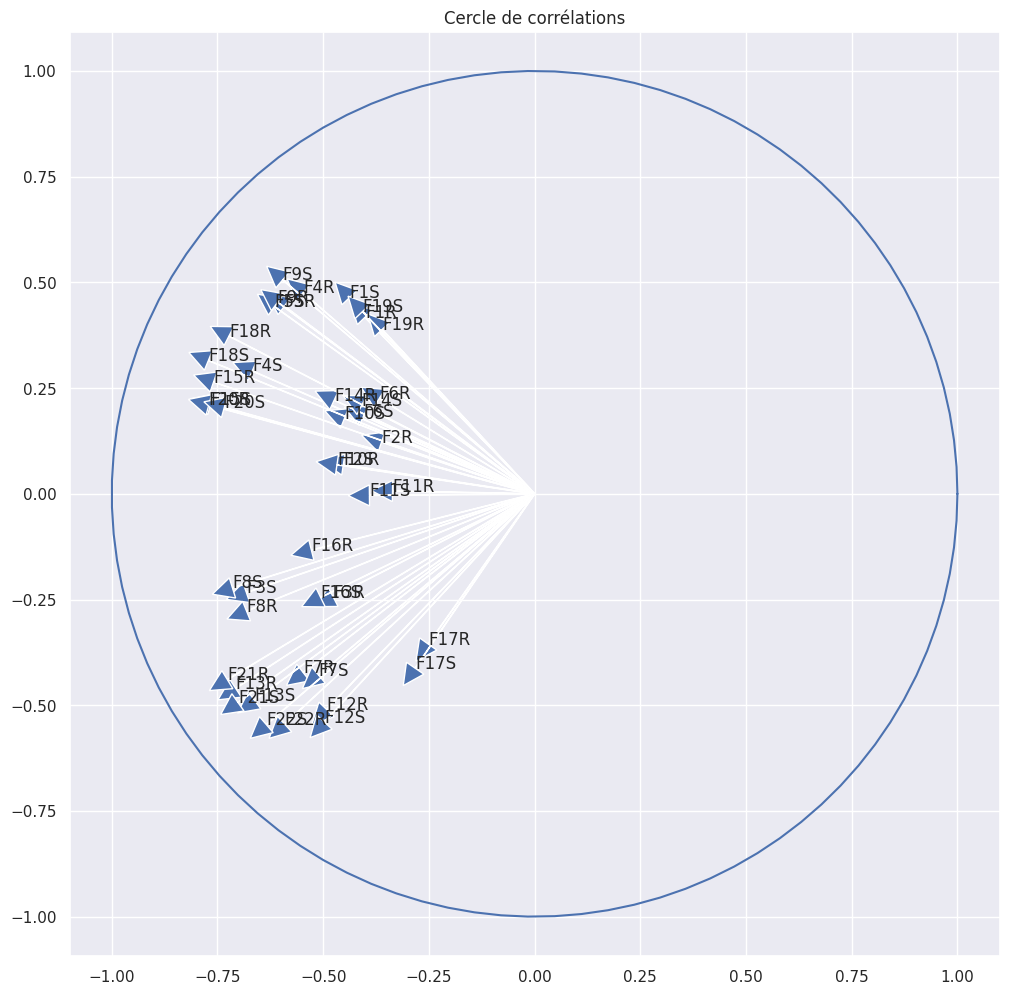

In [16]:
saturations = pca.get_saturations()

(fig, ax) = plt.subplots(figsize=(12, 12))
for i in range(len(pca.eigenvalues)):
	ax.arrow(
		0,
		0,  # Start the arrow at the origin
		saturations[i, 0],
		saturations[i, 1],  # 0 and 1 correspond to dimension 1 and 2
		head_width=0.05,
		head_length=0.05,
	)
	plt.text(saturations[i, 0], saturations[i, 1], df.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
plt.plot(np.cos(an), np.sin(an))
plt.axis("equal")
ax.set_title("Cercle de corrélations")
plt.show()

> Représenter par 2 graphiques à barres (pyplot.bar) la contribution des différentes variables au 1er et au 2ème axes principaux (dans l’ordre décroissant des valeurs).

Text(0, 0.5, 'Contribution')

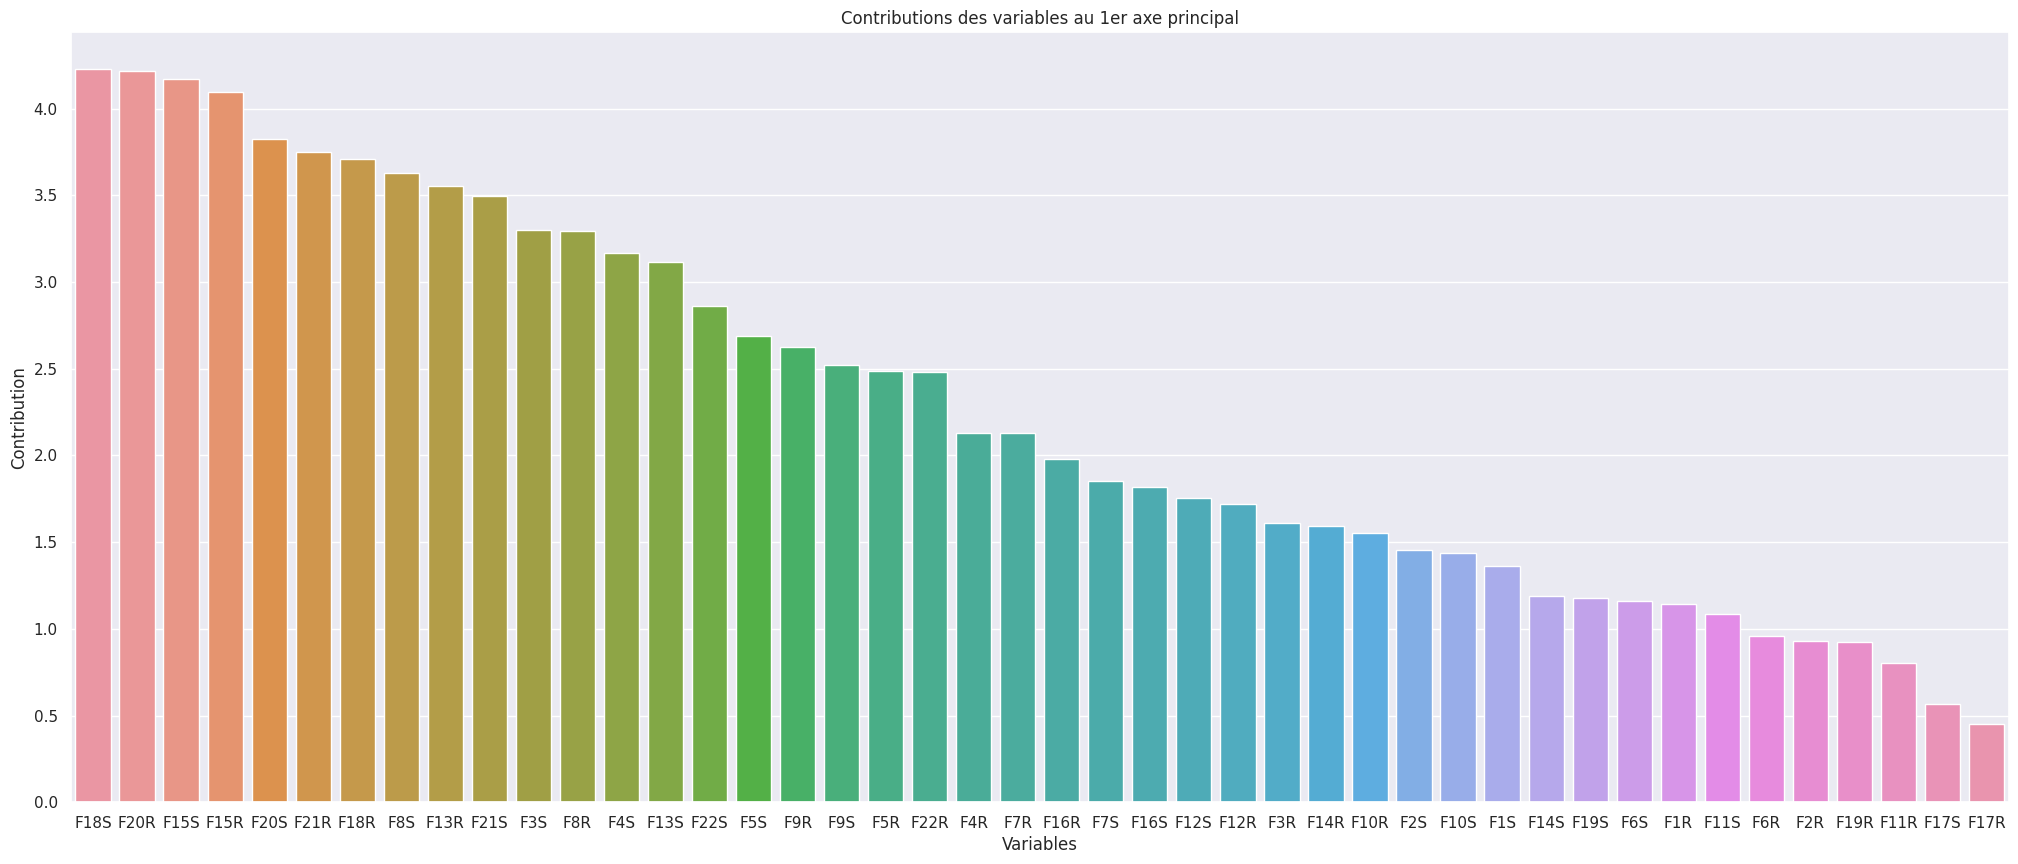

In [17]:
contrib_vars = np.square(pca.eigenvectors)
idx = np.argsort(contrib_vars, axis=0)[::-1]

plt.subplots(figsize=(25, 10))
sns.barplot(x=df.columns[idx[:, 0]], y=contrib_vars[idx[:, 0], 0] * 100)
plt.title('Contributions des variables au 1er axe principal')
plt.xlabel('Variables')
plt.ylabel('Contribution')

Text(0, 0.5, 'Contribution')

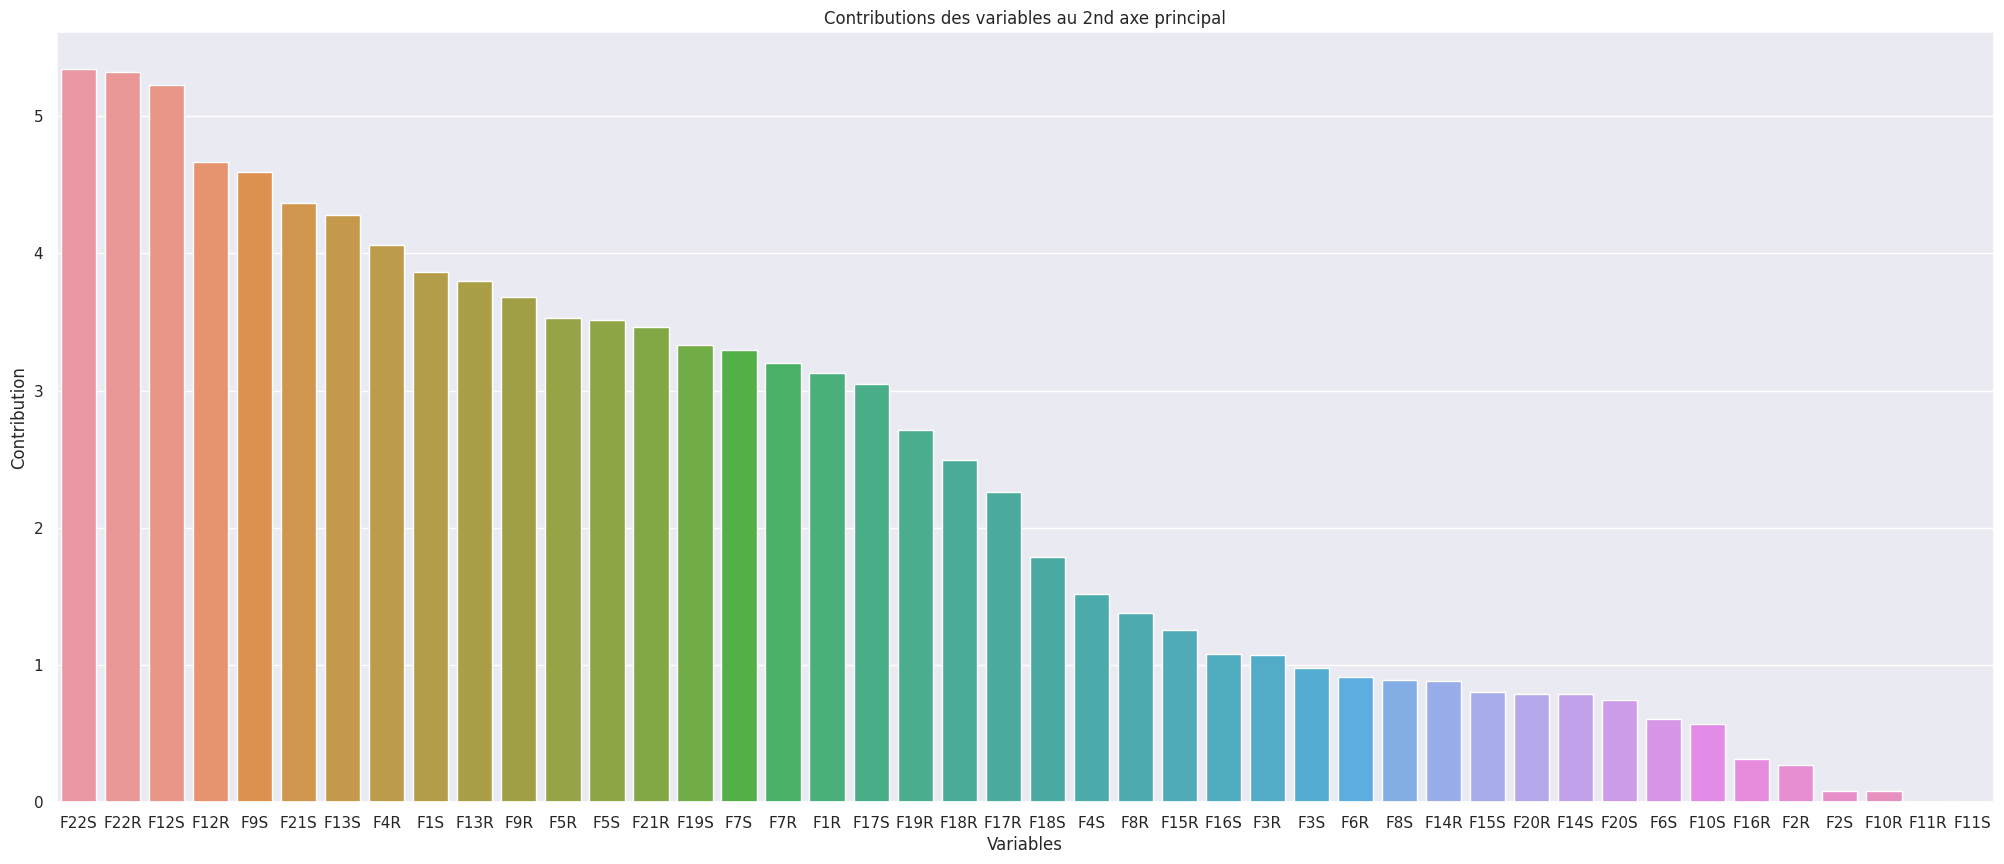

In [18]:
plt.subplots(figsize=(25, 10))
sns.barplot(x=df.columns[idx[:, 1]], y=contrib_vars[idx[:, 1], 1] * 100)
plt.title('Contributions des variables au 2nd axe principal')
plt.xlabel('Variables')
plt.ylabel('Contribution')


> Quelles sont les variables les plus importantes qui expliquent la variabilité des données ? Quelles variables définissent la première composante principale ? La deuxième ?

Les variables corrélées avec la première composante principale (par exemple F18S, F20R, F15R, F15S) et la seconde composante principale (par exemples F22S, F22R, F12S) sont les plus importantes pour expliquer la variabilité dans le jeu de données. Elles définissent également respectivement la première et la deuxième composante principale.

# Exploration des données par partitionnement (clustering)

Tout d'abord nous transformons notre dataframe a l'aide de l'acp et nous gardons seulement les $c$ composantes principales, or ici $c=4$.

In [19]:
pca.set_n_components(4)
df = pca.transform(df)

Ensuite, pour chacun des algorithmes, nous choisirons un nombre de clusters $k$ qui sera égale à $2$, en effet : dans le cas de notre étude, nous cherchons à savoir si les patients ont une perfusion myocardique normal ou non, il n'y a donc que 2 clusters : `normal` et `anormal`.

## Méthode k-means

Nous utilisons la class KMeans que nous avons implémenté en spécifiant le nombre de clusters à 2, puis nous calculons les paramètres de l'algorithme, permettant d'effectuer des prédictions dans le futur à l'aide de la méthode `fit` de la classe.

In [20]:
kmeans = KMeans(2)
kmeans.fit(df)

Converged


La méthode `fit` mets à jour l'attribut `labels_` avec une liste qui associe chacun des individus à un cluster, nous pouvons donc représenter les résultats obtenus avec un `scatterplot` ou la couleur de chacun des points correspond au groupe de l'individu.

Text(0.5, 1.0, "Clustering a l'aide de la méthode k-means")

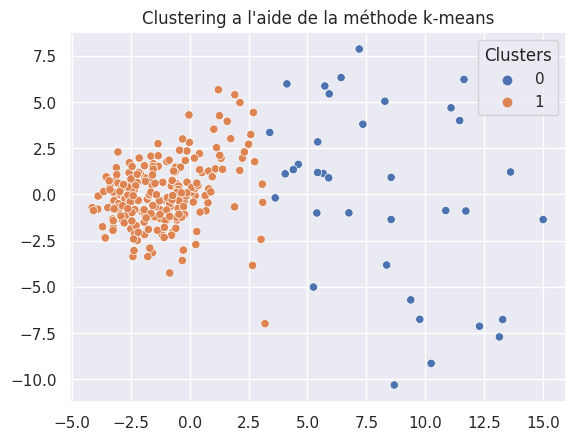

In [21]:
sns.scatterplot(x=plotting_df[:, 0], y=plotting_df[:, 1], hue=kmeans.labels_)
plt.legend(title="Clusters")
plt.title("Clustering a l'aide de la méthode k-means")

## Méthode Spectral

Pour la méthode Spectral, nous avons utilisé le paquet sklearn qui utilise globalement la même api que les classes que nous avons implémenté, ainsi nous faisons de même que pour la méthode K-Means

In [22]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(
	n_clusters=2, eigen_solver="arpack", affinity="nearest_neighbors"
)
spectral.fit(df)

SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=2)

Text(0.5, 1.0, "Clustering a l'aide de la méthode Spectral")

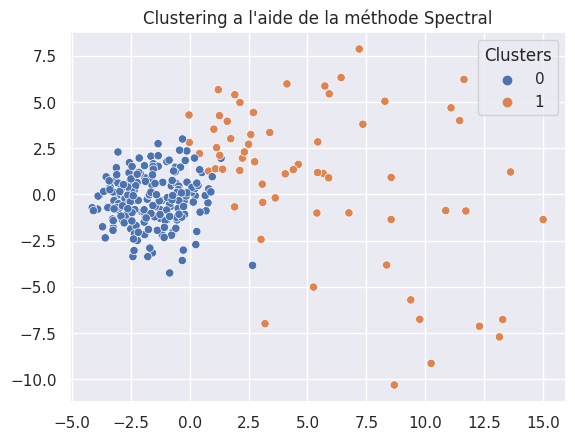

In [23]:
sns.scatterplot(x=plotting_df[:, 0], y=plotting_df[:, 1], hue=spectral.labels_)
plt.legend(title="Clusters")
plt.title("Clustering a l'aide de la méthode Spectral")

## Modèle de mélange Gaussien et algorithme EM

Enfin, pour cet algorithme, nous avons également implémenté à la main notre propre classe avec la même API que pour la méthode K-Means, ce qui nous donne un code identique, ainsi de même que pour K-Means et Spectral :

In [24]:
em = ExpectationMaximisation(2)
em.fit(plotting_df)

Converged


Text(0.5, 1.0, "Clustering a l'aide d'un modèle de mélange Gaussien et de l'algorithme EM")

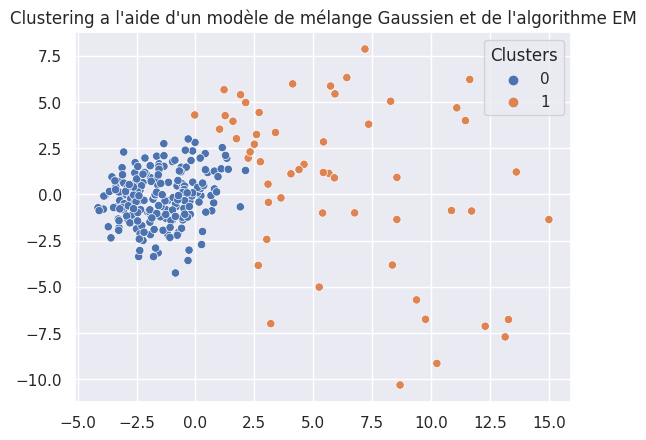

In [25]:
sns.scatterplot(x=plotting_df[:, 0], y=plotting_df[:, 1], hue=em.labels_)
plt.legend(title="Clusters")
plt.title("Clustering a l'aide d'un modèle de mélange Gaussien et de l'algorithme EM")

Cependant, pour vérifier que l'algorithme converge bien ainsi que pour visualiser le mélange gaussien, nous

Text(0.5, 1.0, 'Maximum de vraisemblance (log L)')

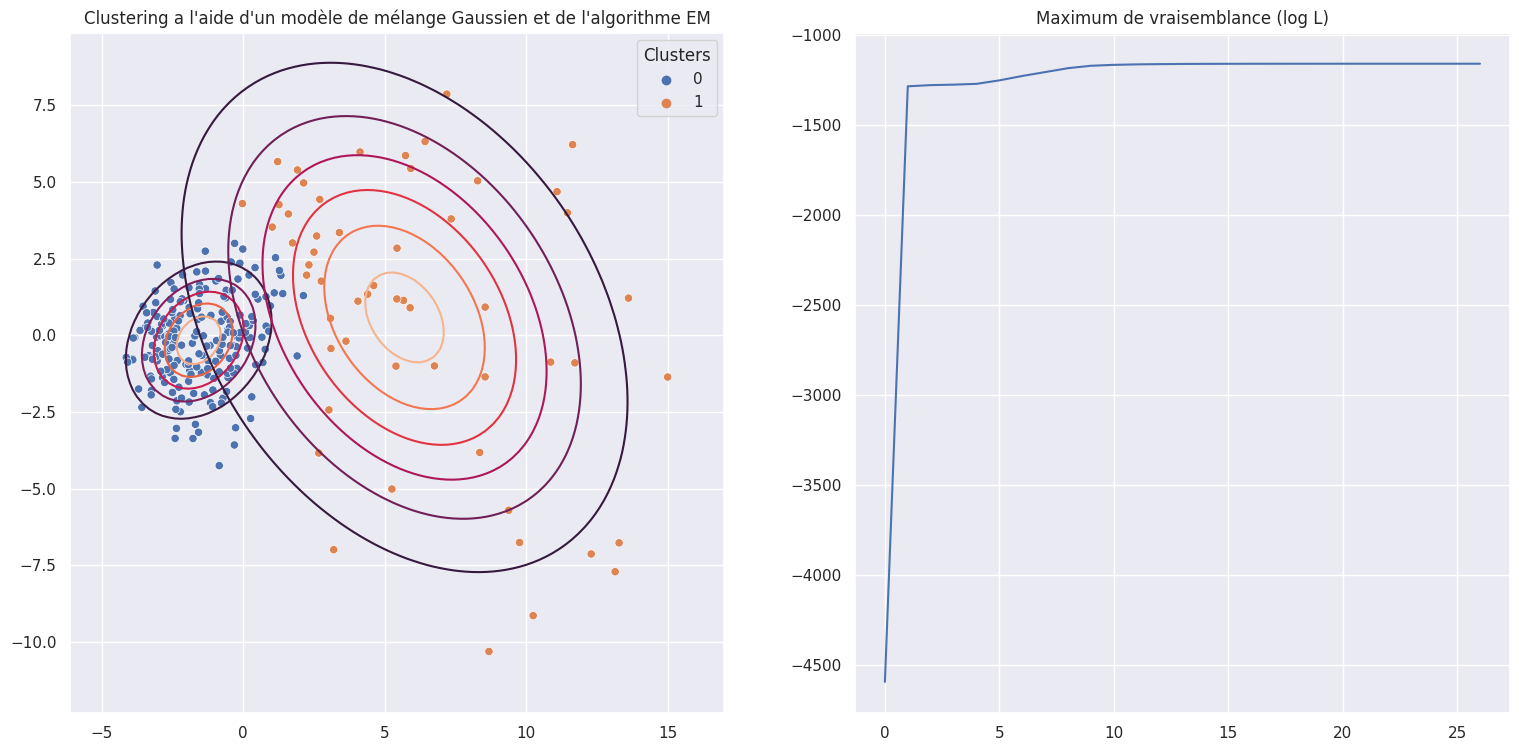

In [26]:
def plot(data, em: ExpectationMaximisation):
	sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=em.labels_)
	x = np.linspace(np.min(data[:, 0])-2, np.max(data[:, 0])+2, 100)
	y = np.linspace(np.min(data[:, 1])-2, np.max(data[:, 1])+2, 100)
	xx, yy = np.meshgrid(x, y)
	coord = np.dstack((xx, yy))

	for i in range(em.k_clusters):
		mn = stats.multivariate_normal(em.parameters[i][0], em.parameters[i][1])
		plt.contour(x, y, mn.pdf(coord))


plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, bottom=0.2, left=0.1)
plt.subplot(121)
plot(plotting_df, em)
plt.legend(title="Clusters")
plt.title("Clustering a l'aide d'un modèle de mélange Gaussien et de l'algorithme EM")
plt.subplot(122)
plt.plot(em.ml)
plt.title("Maximum de vraisemblance (log L)")

## Analyse des résulats

Dans un premier temps nous pouvons afficher chacun des clusters obtenus par les 3 méthodes ainsi que les vrais labels pour comparer visuellement les résultats.

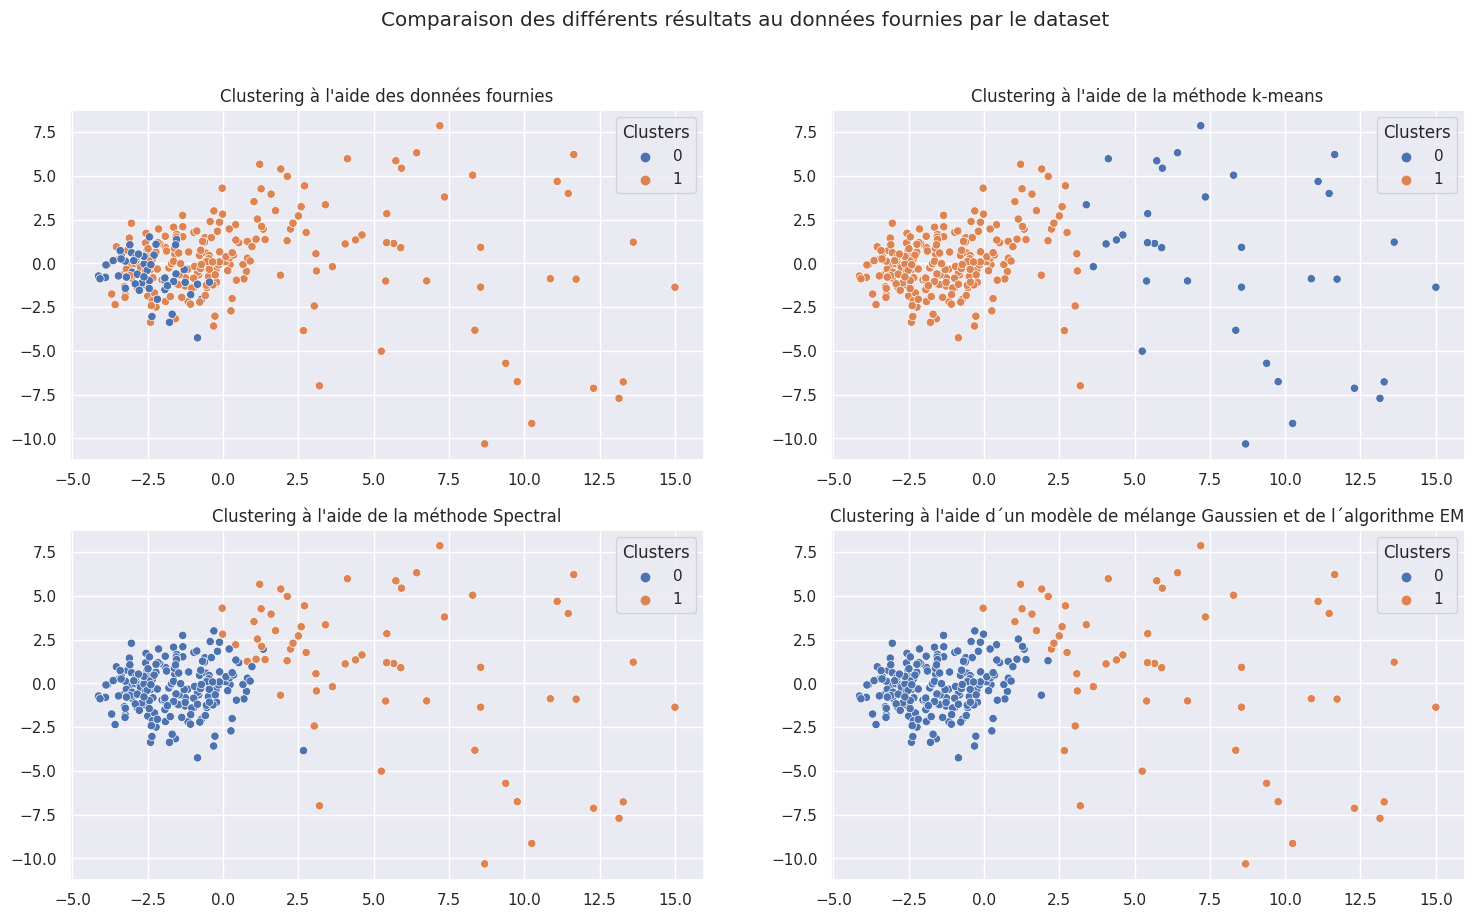

In [27]:
figure, axes = plt.subplots(2, 2, figsize=(18, 10))
figure.suptitle('Comparaison des différents résultats au données fournies par le dataset')

sns.scatterplot(ax=axes[0, 0], x=plotting_df[:, 0], y=plotting_df[:, 1], hue=labels)
sns.scatterplot(ax=axes[0, 1], x=plotting_df[:, 0], y=plotting_df[:, 1], hue=kmeans.labels_)
sns.scatterplot(ax=axes[1, 0], x=plotting_df[:, 0], y=plotting_df[:, 1], hue=spectral.labels_)
sns.scatterplot(ax=axes[1, 1], x=plotting_df[:, 0], y=plotting_df[:, 1], hue=em.labels_)

for index, axe in enumerate(axes.flatten()):
	axe.legend(title="Clusters")
	axe.set_title(f"Clustering à l'aide {['des données fournies', 'de la méthode k-means', 'de la méthode Spectral', 'd´un modèle de mélange Gaussien et de l´algorithme EM'][index]}")


Nous pouvons alors remarquer que globalement les trois clustering donne des résultats similaire et qui diffère grandement du clustering qui nous est fournis dans le jeu de données. Il est également difficile de donnée la méthode la plus efficace pour ces données, étant donné que les 3 clustering sont quasi-identique, cependant il semblerait que ce soit le modèle de mélange Gaussien qui semble le plus proche de la classification fourni même si les clusters reste très éloignés de cette classification. Pour affiner cette observation, nous pouvons utiliser différentes métriques sur les clustering :

### Score silhouette

Par définition le score silhouette, également appelé coefficient de silhouette varie entre -1 et 1, correspondant respectivement au moins bon clustering et au meilleur clustering.


In [28]:
(
	silhouette_score(df, kmeans.labels_),
	silhouette_score(df, spectral.labels_),
	silhouette_score(df, em.labels_),
)

(0.5694302942435795, 0.4700509627766452, 0.5050045599224002)

Ainsi, nous pouvons observer que pour chacun des clustering le score de silhouette est positif et proche de 0.5, d'après cette metrics la meilleure méthode est la méthode k-mean, suivit de la méthode de mélange Gaussien puis finalement de la methode Spectral.

### Indice de Rand

Il correspond a la proportion de paires de points qui sont groupées de la même facon dans chacun des clusters, lorsqu'il est égale a 1 cela signifie que les deux clustering sont identiques.

In [29]:
clusterings = {"kmeans": kmeans.labels_, "spectral": spectral.labels_, "em": em.labels_}
{i: adjusted_rand_score(clusterings[i[0]], clusterings[i[1]]) for i in combinations(clusterings.keys(), 2)}


{('kmeans', 'spectral'): 0.5722380558881562,
 ('kmeans', 'em'): 0.6753680713747687,
 ('spectral', 'em'): 0.8400957511441627}

Nous pouvons alors remarquer que ces valeurs sont proches toutes positive et relativement proche de 1, le clustering issue de la méthode k-means étant le plus différent, et le clustering selon un mélange gaussien et selon la méthode spectrale donnent un clustering très similaire (0.84).